# Intrusion Detection 

## Autore
* **Torroni Alessio** 0365661 

# Introduzione 


Questo Notebook si pone come obiettivo di effettuare un'analisi di molteplici modelli di Machine Learning da applicare al dataset "KDDTrainClean.csv" con il fine di classificare i flussi di rete in modo binario (normale / attacco). Il dataset NSL-KDD rappresenta un benchmark per sistemi di Intrusion Detection. Il dataset contiene informazioni sui flussi di traffico di rete verso una infrastruttura IT. Ciascun flusso è etichettato come “normale” o associato ad una tipologia di attacco. La colonna label del dataset rappresenta l’etichetta target.


# Librerie importate

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelBinarizer, TargetEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from tabulate import tabulate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Caricamento del Dataset 

In [70]:
# Percorso del file
file_path = 'KDDTrainClean.csv'

# Carico il dataset in un DataFrame
df = pd.read_csv(file_path)
print("Dataset caricato con successo.")
print(f"Dimensioni del dataset: {df.shape}")

# Split label in y
X = df.drop('label', axis=1)
y = df['label']

# Trasformazione della variabile target in binaria
y_binary = (y != "normal").astype(int)
y_binary = pd.Series(y_binary)
# Visualizzo le prime righe del dataset
df.head()


Dataset caricato con successo.
Dimensioni del dataset: (125973, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


# Descrizione delle colonne del dataset NSL-KDD

### Caratteristiche di Base
1. **duration:** Durata della connessione in secondi. Utile per rilevare attacchi come DoS, che spesso hanno durate anormalmente brevi o molto lunghe.
2. **protocol_type:** Tipo di protocollo (es. TCP, UDP, ICMP). Alcuni attacchi sfruttano protocolli specifici, come UDP o ICMP.
3. **service:** Tipo di servizio di rete (es. HTTP, FTP, DNS). Aiuta a identificare attacchi mirati a servizi critici, come FTP brute force o HTTP DoS.
4. **flag:** Stato del flag TCP (es. SF, REJ). Modifiche anomale nei flag TCP possono indicare scan di porte.
5. **src_bytes:** Numero di byte inviati dalla sorgente alla destinazione. Valori estremi possono indicare traffico anomalo.
6. **dst_bytes:** Numero di byte inviati dalla destinazione alla sorgente. Sovraccarichi di dati o risposte bloccate sono indicatori di attacco.
7. **land:** Booleano che indica se la sorgente e la destinazione sono lo stesso host. Utile per identificare land attacks.
8. **wrong_fragment:** Numero di frammenti errati nei pacchetti. Attacchi DoS o MITM possono generare frammenti malformati per manipolare il traffico.
9. **urgent:** Numero di pacchetti urgenti nel traffico. Rileva attacchi che abusano del flag URG.
10. **hot:** Numero di indicatori "caldi" in una connessione. Un valore elevato può indicare comportamenti sospetti.
11. **num_failed_logins:** Numero di tentativi di login falliti. Utile per rilevare attacchi brute force.
12. **logged_in:** Booleano che indica se il login è riuscito. Attacchi spesso mostrano tentativi di login non autorizzati.
13. **num_compromised:** Numero di indicatori compromessi in una connessione. Un valore elevato può suggerire che un attacco ha avuto successo.
14. **root_shell:** Booleano che indica se è stato ottenuto accesso root. Accessi root non autorizzati sono chiari segnali di attacco.
15. **su_attempted:** Numero di tentativi di comando `su`(switch user). Rileva attacchi di escalation di privilegi.
16. **num_root:** Numero di accessi root nella connessione. Utile per identificare compromissioni di sistema.
17. **num_file_creations:** Numero di file creati nella sessione. Malware spesso crea file temporanei o modifica il file system.
18. **num_shells:** Numero di shell ottenute nella sessione. Utile per rilevare exploit di sistema.
19. **num_access_files:** Numero di file critici aperti. Rileva accessi sospetti a file riservati.
20. **num_outbound_cmds:** Numero di comandi outbound.
21. **is_host_login:** Booleano che indica login come host.
22. **is_guest_login:** Booleano che indica login come guest.
23. **count:** Numero di connessioni alla stessa destinazione nella finestra temporale. Attacchi come port scan mostrano valori anomali.
24. **srv_count:** Numero di connessioni allo stesso servizio nella finestra temporale. Rileva attacchi mirati contro un servizio specifico.
25. **serror_rate:** Percentuale di connessioni con errori SYN. Utile per rilevare SYN flood.
26. **srv_serror_rate:** Percentuale di errori SYN verso un singolo servizio. Indicativo di attacchi specifici al servizio.
27. **rerror_rate:** Percentuale di connessioni con errori RST. Aiuta a identificare attacchi che generano reset anomali.
28. **srv_rerror_rate:** Percentuale di errori RST verso un singolo servizio. Utile per rilevare attacchi mirati.
29. **same_srv_rate:** Percentuale di connessioni alla stessa destinazione. Cambiamenti drastici possono suggerire comportamenti anomali.
30. **diff_srv_rate:** Percentuale di connessioni verso destinazioni diverse. Un aumento potrebbe indicare scanning di rete.
31. **srv_diff_host_rate:** Percentuale di connessioni a host diversi nello stesso servizio. Utile per rilevare attacchi distribuiti.
32. **dst_host_count:** Numero di connessioni alla destinazione. Una frequenza elevata può indicare un attacco mirato.
33. **dst_host_srv_count:** Numero di connessioni al servizio specifico della destinazione. Utile per rilevare attacchi contro un servizio.
34. **dst_host_same_srv_rate:** Percentuale di connessioni alla stessa destinazione nello stesso servizio. Utile per rilevare abusi di un servizio.
35. **dst_host_diff_srv_rate:** Percentuale di connessioni verso diversi servizi della stessa destinazione. Rileva attacchi a più servizi.
36. **dst_host_same_src_port_rate:** Percentuale di connessioni dalla stessa porta sorgente. Utile per individuare attacchi che sfruttano una porta specifica.
37. **dst_host_srv_diff_host_rate:** Percentuale di connessioni al servizio provenienti da host diversi. Utile per identificare botnet o attacchi distribuiti.
38. **dst_host_serror_rate:** Percentuale di errori SYN sulla destinazione. Cruciale per rilevare SYN flood.
39. **dst_host_srv_serror_rate:** Percentuale di errori SYN sul servizio della destinazione. Indicativo di attacchi mirati.
40. **dst_host_rerror_rate:** Percentuale di errori RST sulla destinazione. Utile per rilevare reset generati da attacchi.
41. **dst_host_srv_rerror_rate:** Percentuale di errori RST sul servizio della destinazione. Utile per identificare attacchi specifici al servizio.

### Target
42. **label:** Indica se il flusso è normale (`normal`) o associato a un attacco (qualsiasi altro valore).


# Pre-processamento dei dati

### Colonne ad alto indice di Correlazione
Notiamo come alcune colonne nel dataset siano altamente correlate tra loro, presentando un coefficiente di correlazione superiore alla soglia di 0.95. Queste relazioni indicano che le feature coinvolte forniscono informazioni ridondanti, poiché rappresentano lo stesso comportamento o fenomeno. Ad esempio, colonne come `serror_rate` e `srv_serror_rate` spesso mostrano valori quasi identici, dato che misurano errori simili in contesti leggermente diversi. Mantenere colonne altamente correlate comporta un aumento della complessità del modello, che si traduce in una maggiore dimensionalità e in un rallentamento del processo di addestramento.  
Eliminare queste colonne ridondanti semplifica il modello, rendendolo più veloce da addestrare e più stabile. 

### Colonne a valori costanti 
Parallelamente, individuiamo colonne costanti che non aggiungono alcuna variabilità al dataset. Queste colonne, avendo lo stesso valore per tutti i record, non influenzano il processo decisionale del modello e possono essere considerate inutili. Mantenere colonne costanti comporta un aumento della dimensionalità del dataset senza alcun beneficio informativo, oltre a rappresentare uno spreco di risorse computazionali, incrementando i tempi di addestramento e il consumo di memoria.

Questa attività di preprocessamento garantisce che il dataset sia ottimizzato per l'addestramento, mantenendo solo le feature più rilevanti e significative, migliorando così sia l'efficienza del modello che la sua capacità di generalizzazione.

### Calcolo della matrice di Correlazione  

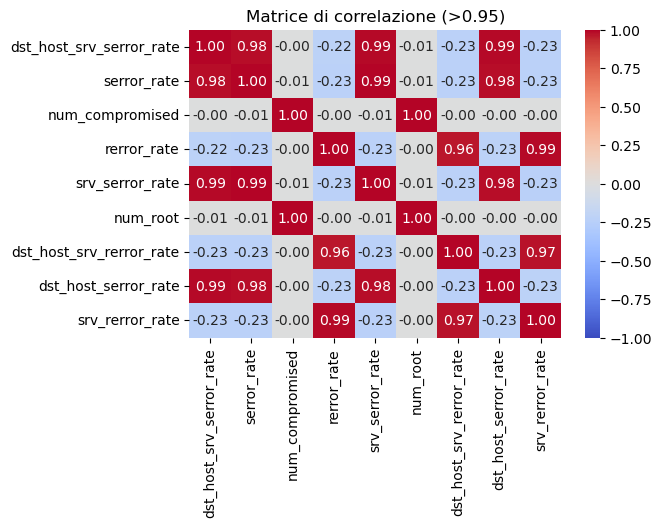

Coppie di colonne altamente correlate con percentuale di correlazione:


,Feature 1,Feature 2,Correlation Index
0,num_compromised,num_root,99.883345
1,serror_rate,srv_serror_rate,99.328924
2,serror_rate,dst_host_serror_rate,97.937308
3,serror_rate,dst_host_srv_serror_rate,98.113896
4,srv_serror_rate,dst_host_serror_rate,97.759601
5,srv_serror_rate,dst_host_srv_serror_rate,98.625172
6,rerror_rate,srv_rerror_rate,98.900765
7,rerror_rate,dst_host_srv_rerror_rate,96.444867
8,srv_rerror_rate,dst_host_srv_rerror_rate,97.020800
9,dst_host_serror_rate,dst_host_srv_serror_rate,98.505222


In [72]:
# Calcolo della matrice di correlazione 
correlation_matrix = X.corr(numeric_only=True)
highly_correlated_pairs = []
threshold = 0.95

for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            highly_correlated_pairs.append((
                correlation_matrix.index[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

# Stampa matrice delle feature altamente correlate 
plt.figure(figsize=(6, 4))
correlated_features = list(set([item for sublist in highly_correlated_pairs for item in sublist[:2]]))
correlation_matrix_filtered = correlation_matrix.loc[correlated_features, correlated_features]
sns.heatmap(correlation_matrix_filtered, cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title("Matrice di correlazione (>0.95)")
plt.show()

# Stampa tabella coppie altamente correlate 
correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation Index'])
correlated_df['Correlation Index'] = correlated_df['Correlation Index'].abs() * 100  # Converto in percentuale
print("Coppie di colonne altamente correlate con percentuale di correlazione:")
correlated_df.head(10)


## Rimozione delle feature costanti ed altamente correlate 
Analizzando le feature dalla matrice di correlazione, controlliamo quanto sono correlate con la feature target. Notiamo che le coppie più correlate hanno coefficienti di correlazione con il target molto simili. Per questo, scegliamo di rimuovere la feature con il coefficiente di correlazione più basso rispetto al target.

In [74]:
# Rimuovi feature a valori costanti
constant_columns = [col for col in X.columns if X[col].nunique() == 1]
X = X.drop(columns=constant_columns)

# iteriamo fino a che non ci sono piu coppie correlate (viene fatto per non perdere se ci sono 3 feature in mutua correlazione)
while True:
    correlation_matrix = X.corr(numeric_only=True)
    highly_correlated_pairs = []

    # cerca feature altamente correlate 
    for i in range(correlation_matrix.shape[0]):
        for j in range(i + 1, correlation_matrix.shape[1]):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                highly_correlated_pairs.append((
                    correlation_matrix.index[i], 
                    correlation_matrix.columns[j], 
                    correlation_matrix.iloc[i, j]
                ))

    #usciamo dal ciclo se non ci sono piu coppie
    if not highly_correlated_pairs:
        break

    # feature da rimuovere 
    features_to_remove = []
    visited = set()
    
    for feature1, feature2, _ in highly_correlated_pairs:
        if feature1 not in visited and feature2 not in visited:
            # confontiamo correlazione con il target
            corr_feature1 = X[feature1].corr(y_binary)
            corr_feature2 = X[feature2].corr(y_binary)

            # Rimuoviamo la feature con correlazione minore 
            if abs(corr_feature1) >= abs(corr_feature2):
                features_to_remove.append(feature2)
            else:
                features_to_remove.append(feature1)

            visited.add(feature1)
            visited.add(feature2)

    X = X.drop(columns=features_to_remove)
    print("Feature rimosse per alta correlazione:", features_to_remove)

print("Numero di feature rimanenti: ",len(X.columns))

Feature rimosse per alta correlazione: ['num_compromised', 'srv_serror_rate', 'rerror_rate', 'dst_host_serror_rate']
Feature rimosse per alta correlazione: ['serror_rate', 'dst_host_srv_rerror_rate']
Numero di feature rimanenti:  34


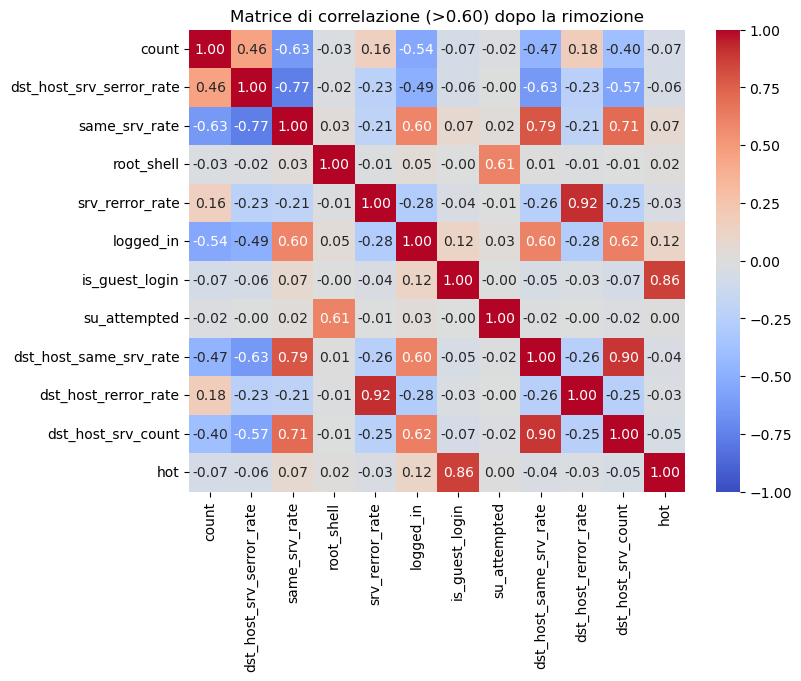

In [76]:
# Calcolo della matrice di correlazione (dopo la rimozione) con soglia 0.60
correlation_matrix = X.corr(numeric_only=True)
highly_correlated_pairs = []
threshold = 0.60

for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            highly_correlated_pairs.append((
                correlation_matrix.index[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

# Stampa matrice delle feature con correlazione superiore al 60%
plt.figure(figsize=(8, 6))
correlated_features = list(set([item for sublist in highly_correlated_pairs for item in sublist[:2]]))
correlation_matrix_filtered = correlation_matrix.loc[correlated_features, correlated_features]
sns.heatmap(correlation_matrix_filtered, cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title("Matrice di correlazione (>0.60) dopo la rimozione")
plt.show()

# Divisione del Dataset 

Quando si valuta un modello di Machine Learning, l'intero data set deve essere scomposto in 3 parti:

* **training set**: porzione del data set utilizzata per addestrare il modello;
* **validation set**: porzione del data set utilizzata per stabilire quali sono i valori degli iperparametri che portano il modello ad avere le prestazioni migliori.
* **testing set**: porzione del data set utilizzata confrontare il valore vero col valore predetto del target di ciascun elemento e calcolare le prestazioni e la qualità del modello scelto.

Il data set viene tipicamente suddiviso secondo il seguente schema:

* Si ha una prima suddivisione statica in training+validation set e testing set: circa il 70-80% delle istanze andrebbe nel training+validation set, mentre il restante 20-30% andrebbe nel testing set. In questo progetto, verrà effettuata una suddivisione del tipo: 80% dei dati nel training+validation set; 20% dei dati nel testing set.
* Per quanto riguarda il training+validation set, nel caso in cui si ha a che fare con un modello che prevede il settaggio di qualche iperparametro, si è deciso di suddividere in: 75% training set e 25% validation set. 

Si è scelto di effettuare la divisione del dataset prima della normalizzazione dei dati per evitare problemi di **data leakage** ovvero l'inclusione accidentale di informazioni dal test set , che altera i risultati e porta a modelli non generalizzabili, poiché il modello impara da dati che non avrebbe normalmente accesso durante la predizione.

https://arxiv.org/pdf/2207.07048

In [78]:
# Suddivisione iniziale: 80% training+validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, shuffle=True)

# Suddivisione del training+validation in 75% training, 25% validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True)

Nel dividere il dataset prima della normalizzazione, si è notato che si potrebbe incorrere nel problema della **sensibilità alla suddivisione dei dati**, ovvero una forte dipendenza del modello da come i dati vengono separati tra training e test, con il rischio di ottenere performance incoerenti su diversi split. 

Per verificare se è presente questo problema, ho voluto testare il modello KNN iterando su più shuffle del dataset. In particolare, ho suddiviso ripetutamente i dati in training, validation e test set, valutando il modello su diverse configurazioni per osservare se le performance cambiassero significativamente.

Inoltre, per evitare che il modello fosse influenzato da dataset sbilanciati, ho aggiunto un controllo sul bilanciamento delle classi nel training set.

In conclusione, questo test ha permesso di valutare la stabilità del modello e di garantire che le prestazioni non fossero fortemente dipendenti dalla suddivisione dei dati.

https://github.com/Alessio1100/ML_Intrusion_Detection/blob/main/Test_Shuffle_Dataset.ipynb

### Controllo che la distribuzione delle classi sia bilanciata 

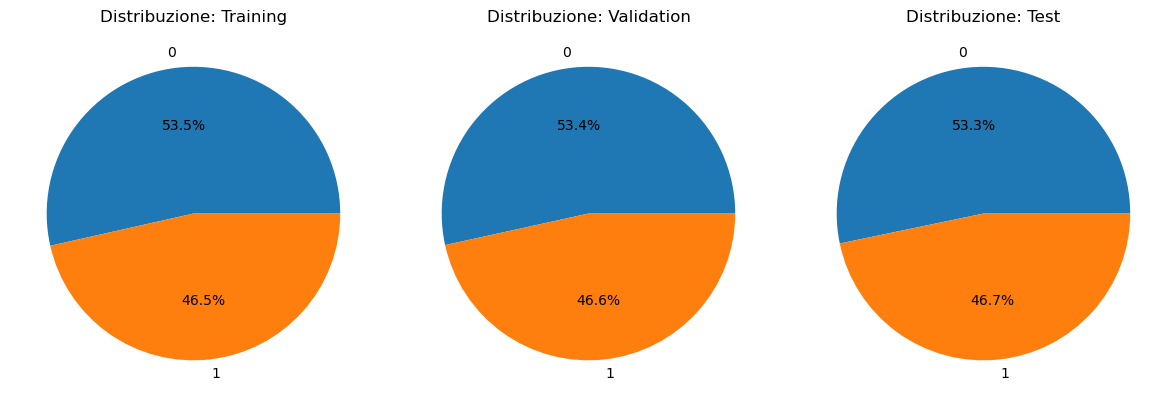

In [80]:
# Funzione per verificare il bilanciamento delle classi
def verifica_bilanciamento(y, set_name, ax):
    distribuzione = y.value_counts(normalize=True)
    ax.pie(np.array(distribuzione), labels=[0, 1], autopct='%1.1f%%')
    ax.set_title(f"Distribuzione: {set_name}")

# Creazione dei subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 riga, 3 colonne, dimensione totale

# Verifica per ogni set
verifica_bilanciamento(pd.Series(y_train), "Training", axes[0])
verifica_bilanciamento(pd.Series(y_val), "Validation", axes[1])
verifica_bilanciamento(pd.Series(y_test), "Test", axes[2])

# Mostrare i grafici
plt.tight_layout()  # Per evitare sovrapposizioni
plt.show()


# Pipeline e Normalizzazione

Affinché tutte le feature diano lo stesso contributo nell'apprendimento dei modelli di Machine Learning, è necessario che i loro valori viaggino sullo stesso ordine di grandezza. Invece noi abbiamo:

* **duration**: assume valori tra 0 e 42908
* **src_bytes**: assume valori tra 0 e 1379963888
* **dst_bytes**: assume valori tra 0 e 1309937401
* **num_compromised**: assume valori tra 0 e 7479
* **num_root**: assume valori tra 0 e 7468
* **count**: assume valori tra 0 e 511
* **srv_count**: assume valori tra 0 e 511
* **dst_host_count**: assume valori tra 0 e 255
* **dst_host_srv_count**: assume valori tra 0 e 255

Tali feature verranno normalizzate utilizzando  **MinMaxScaler**, una tecnica di normalizzazione che ridimensiona i dati in un **intervallo** tra \([0,1]\). La formula utilizzata è:
$$ x' = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}$$
Questa trasformazione preserva la **distribuzione originale** dei dati, riducendo l'influenza di scale diverse tra le feature.

### Feature Categoriche
Per quanto riguarda le feature categoriche abbiamo:

* **protocol_type**: 'tcp','udp','icmp' 
* **service**: come vediamo qui di seguito assume 70 valori unici	
* **flag**: 'SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH'
* **label**: nel caso generico assume piu di due valori. Siccome il nostro obbiettivo è una classificazione binaria normalizziamo la feature ponendo
0 se il flusso è normale e 1 se è un attacco.

Le feature categoriche che assumono un numero di valori distinti ragionevolmente piccolo come **protocol_type** e **flag** vengono codificate attraverso **One Hot Encoding**


La feature categorica **service** per motivi di dimensionalità viene codificata attraverso *TargetEncoder()*. La classe `TargetEncoder`, implementa una tecnica di **codifica categoriale** combinando la media globale della variabile target con la media condizionata per ciascuna categoria. Per evitare l'**overfitting**, applica uno smoothing bayesiano.

#### **Formula del Target Encoding**

$$
\text{Encoding}(c) = \frac{\sum_{i=1}^{N_c} y_i + \alpha \cdot \mu}{N_c + \alpha}
$$

Dove:
* ${c}$ è una categoria specifica della feature categoriale. 
* ${N_c}$ è il numero di occorrenze della categoria ${ c } $ nel dataset. 
* ${ y_i }$ sono i valori della variabile target associati alla categoria ${c}$. 
* ${\mu }$ è la **media globale** del target su tutto il dataset.
* ${ \alpha }$ è un **parametro di smoothing** che bilancia l'influenza tra la media condizionata della categoria e la media globale.


## Preparazione dei dati

In [82]:
#Distinguo feature numeriche binarie e non 
num_attribs = [
    col for col in X.columns
    if X[col].dtype in ['int64', 'float64'] and X[col].max() > 1
]
skip_attribs = [
    col for col in X.columns
    if X[col].dtype in ['int64', 'float64'] and X[col].max() <= 1
]
num_attribs_high = [
    col for col in X.columns
    if X[col].dtype in ['int64', 'float64'] and X[col].max() > 10^4
]
skip_attribs_low= [
    col for col in X.columns
    if X[col].dtype in ['int64', 'float64'] and X[col].max() <= 10^4
]
#Distinguo feature categoriche ad alta dimensionalità
cat_attribs = ["protocol_type", "flag"]
cat_attribs_high_dim = ["service"]

X_train[cat_attribs] = X_train[cat_attribs].astype(str)
X_train[cat_attribs_high_dim] = X_train[cat_attribs_high_dim].astype(str)

X_test[cat_attribs] = X_test[cat_attribs].astype(str)
X_test[cat_attribs_high_dim] = X_test[cat_attribs_high_dim].astype(str)


## Creazione della pipeline
Applicare manualmente tutte le trasformazioni necessarie sui dati di training e test, come la gestione dei valori mancanti e la creazione di nuove feature, può essere un processo lungo e soggetto a errori. Le pipeline di trasformazione di scikit-learn automatizzano questi passaggi, garantendo che le stesse operazioni vengano applicate in modo coerente e riproducibile su tutti i dati.

L'uso della pipeline consente di suddividere il preprocessing in fasi distinte, adattando le trasformazioni alle diverse tipologie di feature. I dati numerici vengono normalizzati per garantire che siano confrontabili tra loro, mentre le variabili categoriche vengono trasformate per essere utilizzabili dai modelli di machine learning. 
Un vantaggio dell’uso della pipeline è la flessibilità: ogni modello ha esigenze diverse in termini di preprocessing, e la pipeline permette di applicare solo le trasformazioni necessarie, senza introdurre operazioni superflue.

Nello specifico per i modelli sensibili alle scale dei dati vengono applicate tutte le tecniche di normalizzazione sopra indicate. Tra queste abbiamo:
* **Feedforward NN**
* **K-Nearest Neighbor**
* **Logistic Regression**
  
Per quanto riguarda gli algoritmi basati su alberi come **AdaBoost** e **Random Forest** sono invarianti rispetto alla scala delle feature. Tuttavia se i dati contengono feature con scale estreme, come nel caso di *src_bytes* e *dst_bytes*, potrebbe essere utile una trasformazione logaritmica per evitare che alcune feature abbiano più impatto di altre.



In [84]:
# Creazione del trasformatore logaritmico per feature con scala troppo elevata 
log_transformer = FunctionTransformer(np.log1p, validate=True)

#Pipeline per la normalizzazione delle feature numeriche 
num_pipeline_normalized = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Riempie i valori mancanti
    ("scaler", MinMaxScaler())  # Normalizzazione tra 0 e 1 
])
#Pipeline per saltare la normalizzazione delle feature numeriche per modelli che non necessitano di normalizzazione 
num_pipeline_passthrough = "passthrough" 

full_pipeline_models = {
    "Feedforward_NN": ColumnTransformer([        # Feedforward Neural Network, molto sensibile alla scala dei dati --> normalizziamo tutte le feature
        ("num", num_pipeline_normalized, num_attribs),        
        ("num_pass", num_pipeline_passthrough,skip_attribs),
        ("cat_oht", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
        ("cat_tge", TargetEncoder(), cat_attribs_high_dim),
    ]), 
    "KNN": ColumnTransformer([                    # KNN sensibile alla scala dei dati --> normalizziamo tutte le feature
        ("num", num_pipeline_normalized, num_attribs),
        ("num_pass", num_pipeline_passthrough,skip_attribs),
        ("cat_oht", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
        ("cat_tge", TargetEncoder(), cat_attribs_high_dim),
    ]),
    "Logistic_Regression": ColumnTransformer([    # Logistc Regression sensibile alla scala dei dati --> normalizziamo tutte le feature
        ("num", num_pipeline_normalized, num_attribs),
        ("num_pass", num_pipeline_passthrough,skip_attribs),
        ("cat_oht", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
        ("cat_tge", TargetEncoder(), cat_attribs_high_dim),
    ]),
    "Random_Forest": ColumnTransformer([          # Random Forest non sensibile alla scala dei dati --> normalizziamo le feature categoriche 
        ("num", log_transformer, num_attribs_high),                                                     # e le feature con scala elevata
        ("num_pass", num_pipeline_passthrough,skip_attribs_low),
        ("cat_oht", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
        ("cat_tge", TargetEncoder(), cat_attribs_high_dim),
    ]),
    "AdaBoost": ColumnTransformer([              # Random Forest non sensibile alla scala dei dati --> normalizziamo le feature categoriche
        ("num", log_transformer , num_attribs_high),                                                     # e le feature con scala elevata
        ("num_pass", num_pipeline_passthrough,skip_attribs_low),
        ("cat_oht", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
        ("cat_tge", TargetEncoder(), cat_attribs_high_dim),
    ])
}

## Funzione per il processamento della pipeline

In [86]:
def preprocess_pipeline(model_name):
    
    global X_train, X_val, X_test, y_train

    if model_name not in full_pipeline_models:
        raise ValueError(f"Modello '{model_name}' non trovato.")

    # Selezioniamo la pipeline specifica per il modello
    pipeline = full_pipeline_models[model_name]

    # Fit della pipeline sul training set
    pipeline.fit(X_train,y_train)

    # Funzione per ottenere i nomi delle colonne trasformate
    def get_feature_names(column_transformer, input_features):
        output_feature_names = []
        for name, transformer, columns in column_transformer.transformers_:
            if name == "remainder":
                output_feature_names.extend(columns)  # Colonne pass-through
            elif hasattr(transformer, "get_feature_names_out"):
                # Per trasformatori come OneHotEncoder
                feature_names = transformer.get_feature_names_out(columns)
                output_feature_names.extend(feature_names)
            else:
                # Per trasformazioni come TargetEncoder
                output_feature_names.extend(columns)
        return output_feature_names

    # Recuperiamo i nomi delle colonne trasformate
    transformed_columns = get_feature_names(pipeline, X_train.columns)

    # Trasformiamo i Set
    X_train_transformed = pd.DataFrame(
        pipeline.transform(X_train),
        index=X_train.index,
        columns=transformed_columns
    )
    X_val_transformed = pd.DataFrame(
        pipeline.transform(X_val),
        index=X_val.index,
        columns=transformed_columns
    )
    X_test_transformed = pd.DataFrame(
        pipeline.transform(X_test),
        index=X_test.index,
        columns=transformed_columns
    )
    
    return X_train_transformed, X_val_transformed, X_test_transformed


## Metriche Utilizzate
- **Accuracy**:    $ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $
  
- **Precision**:    $\text{Precision} = \frac{TP}{TP + FP}$
  
- **Recall**:     $\text{Recall} = \frac{TP}{TP + FN}$

- **F1-score**:    $\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

- **Confusion Matrix**

In [88]:
results_dictionary={}
def metrics_score(y_true, y_pred):
    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, average='weighted')
    metrics['Recall'] = recall_score(y_true, y_pred, average='weighted')
    metrics['F1-Score'] = f1_score(y_true, y_pred, average='weighted')
    return metrics

# Feedforward Neural Network

La rete neurale è stata progettata con due livelli nascosti, la cui dimensione è stata ottimizzata durante la fase di ricerca degli iperparametri. La scelta di due livelli nascosti è motivata dal fatto che un singolo strato potrebbe non essere sufficiente per catturare relazioni complesse nei dati, mentre un numero eccessivo potrebbe portare a overfitting o tempi di addestramento elevati.

Il numero iniziale di neuroni nei livelli nascosti è stato selezionato attraverso iperparamentri.

Il Dropout è stato introdotto per ridurre l'overfitting, eliminando casualmente una frazione dei neuroni durante l'addestramento. Il droput rate è stato scelto attraverso iperparametri

Per trovare la combinazione ottimale di iperparametri, è stato utilizzato RandomizedSearchCV invece di un GridSearchCV tradizionale per motivi di efficienza computazionale e maggiore esplorazione dello spazio.

L'Early Stopping è stato introdotto per interrompere l'addestramento quando il modello smette di migliorare, evitando così l'overfitting e risparmiando risorse computazionali.


In [90]:
# Preprocessing del dataset per la rete neurale
X_train_fnn, X_val_fnn, X_test_fnn = preprocess_pipeline("Feedforward_NN")


def create_nn_model(optimizer='adam', neurons_1=64, neurons_2=32, dropout_rate=0.5):
    model = Sequential()
    model.add(tf.keras.Input(shape=(X_train_fnn.shape[1],)))  # Definizione esplicita dell'input
    model.add(Dense(neurons_1, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons_2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

keras_model = KerasClassifier(model=create_nn_model, verbose=0)

# Definizione della distribuzione degli iperparametri
param_dist = {
    'model__optimizer': ['adam', 'rmsprop', 'sgd', 'adagrad', 'nadam'],
    'model__neurons_1': [64, 128, 256, 512],
    'model__neurons_2': [32, 64, 128, 256],
    'model__dropout_rate': [0.4, 0.5, 0.6, 0.7],
    'batch_size': [16, 32, 64, 128],
    'epochs': [30, 50]
}

# RandomizedSearchCV per trovare i migliori iperparametri
random_search = RandomizedSearchCV(
    estimator=keras_model,
    param_distributions=param_dist,
    n_iter=20,  # Numero di combinazioni da testare
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation sul training set
    verbose=1,
    random_state=42
)

# Applicare RandomizedSearchCV sul training set
random_search.fit(X_train_fnn, y_train)

# Migliori parametri trovati
best_params_fnn = random_search.best_params_
print(f"Migliori parametri trovati: {best_params_fnn}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Migliori parametri trovati: {'model__optimizer': 'adam', 'model__neurons_2': 256, 'model__neurons_1': 256, 'model__dropout_rate': 0.5, 'epochs': 50, 'batch_size': 32}


In [96]:
#Migliori iperparametri trovati: {'model__optimizer': 'nadam', 'model__neurons_2': 32, 'model__neurons_1': 64, 'model__dropout_rate': 0.2, 'epochs': 50, 'batch_size': 128}
best_params_fnn = {
    'model__optimizer': 'nadam',
    'model__neurons_1': 64,
    'model__neurons_2': 32,
    'model__dropout_rate': 0.2,
    'epochs': 50,
    'batch_size': 128
}

# Definizione di Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=5,           
    restore_best_weights=True  
)

# Creazione e addestramento del modello con i migliori iperparametri trovati
fitted_nn = create_nn_model(
    optimizer=best_params_fnn['model__optimizer'],
    neurons_1=best_params_fnn['model__neurons_1'],
    neurons_2=best_params_fnn['model__neurons_2'],
    dropout_rate=best_params_fnn['model__dropout_rate']
)

history = fitted_nn.fit(
    X_train_fnn, y_train,
    validation_data=(X_val_fnn, y_val),
    epochs=best_params_fnn['epochs'],
    batch_size=best_params_fnn['batch_size'],
    callbacks=[early_stopping],
    verbose=1
)

# Predizione sul validation set
y_pred_nn = fitted_nn.predict(X_val_fnn)
y_pred_nn = (y_pred_nn > 0.5).astype(int).flatten()

# Calcolo delle metriche di valutazione
metrics_nn = metrics_score(y_val, y_pred_nn)

# Memorizzazione dei risultati
results_dictionary["Neural Network"] = metrics_nn
print("Model fit done: Metrics saved in results_dictionary!")

Epoch 1/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9003 - loss: 0.2418 - val_accuracy: 0.9763 - val_loss: 0.0650
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9771 - loss: 0.0693 - val_accuracy: 0.9829 - val_loss: 0.0476
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9809 - loss: 0.0507 - val_accuracy: 0.9852 - val_loss: 0.0397
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9833 - loss: 0.0438 - val_accuracy: 0.9866 - val_loss: 0.0341
Epoch 5/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9864 - loss: 0.0377 - val_accuracy: 0.9893 - val_loss: 0.0306
Epoch 6/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9883 - loss: 0.0331 - val_accuracy: 0.9897 - val_loss: 0.0287
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9897 - loss: 0.0295 - val_accuracy: 0.9916 - val_loss: 0.0244
Epoch 8/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9907 - loss: 0.0263 - val_accuracy: 0.

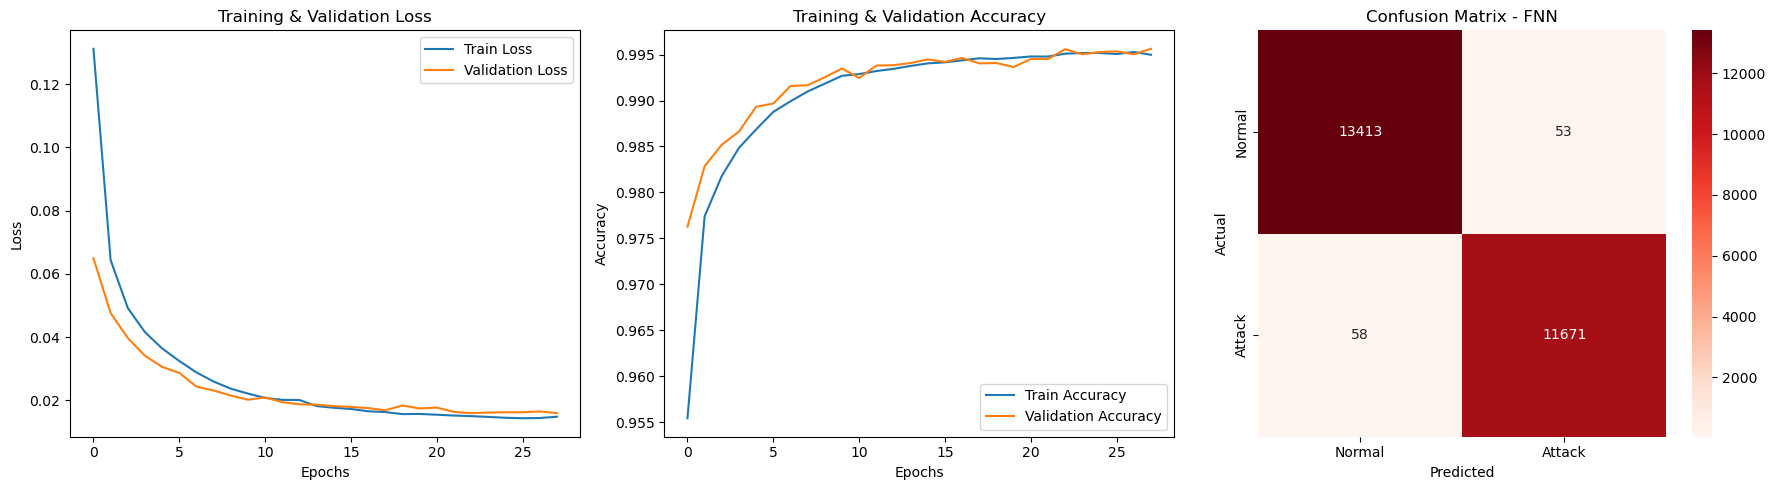

Feedforward Neural Network
+-----------+----------+
|  Metric   |  Value   |
+===========+==========+
| Accuracy  | 0.995594 |
+-----------+----------+
| Precision | 0.995594 |
+-----------+----------+
|  Recall   | 0.995594 |
+-----------+----------+
| F1-Score  | 0.995594 |
+-----------+----------+


In [104]:
# Creazione della figura con 3 sottoplot in una riga
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Grafico della loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()

# Grafico dell'accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()

# Matrice di confusione
sns.heatmap(confusion_matrix(y_val, y_pred_nn), annot=True, fmt="d", cmap="Reds", 
            xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"], ax=axes[2])
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")
axes[2].set_title("Confusion Matrix - FNN")

# Mostra tutti i grafici
plt.tight_layout()
plt.show()

          
# Tabella delle metriche
table_nn = [["Accuracy", metrics_nn["Accuracy"]],
         ["Precision", metrics_nn["Precision"]],
         ["Recall", metrics_nn["Recall"]],
         ["F1-Score", metrics_nn["F1-Score"]]]

print("Feedforward Neural Network")
print(tabulate(table_nn, headers=["Metric", "Value"], tablefmt="grid", colalign=("center", "center")))




L’analisi della matrice di confusione mostra che il modello ha classificato correttamente la maggior parte dei flussi di rete, con un numero minimo di falsi positivi e falsi negativi.

Il grafico della loss mostra una convergenza rapida senza evidenti segni di overfitting, grazie all'uso del Dropout e dell’Early Stopping. Allo stesso modo, il grafico dell'accuracy evidenzia una performance consistente tra il training set e il validation set, indicando che il modello generalizza bene sui dati non visti.

# K-Nearest Neighbors(KNN)
La ricerca degli iperparametri per **K-Nearest Neighbors** (KNN) è stata effettuata con **RandomizedSearchCV**, testando:

* Il **numero di vicini** (n_neighbors)
* Il **tipo di peso dei vicini** (weights)
* La **metrica di distanza** (metric)

L’uso di RandomizedSearchCV è motivato dall’efficienza computazionale, permettendo di esplorare rapidamente lo spazio degli iperparametri senza il costo di una ricerca esaustiva.

In [43]:
X_train_knn, X_val_knn, X_test_knn = preprocess_pipeline("KNN")

# Definizione del modello KNN
knn = KNeighborsClassifier()

# Definizione della distribuzione degli iperparametri
param_distributions = {
    'n_neighbors': np.arange(1, 21),  # Numero di vicini (1-20)
    'weights': ['uniform', 'distance'],  # Peso uniforme o basato sulla distanza
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Metriche di distanza
}

# RandomizedSearchCV per trovare i migliori iperparametri
random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_distributions,
    n_iter=20,  # Numero di combinazioni casuali da testare
    scoring='accuracy',  # Metrica principale
    cv=5,  # 5-fold cross-validation sul training set
    verbose=1,
    n_jobs=1,  # Se ci sono problemi con multiprocessing, prova con 1
    random_state=42  # Per riproducibilità
)

# Applicare RandomizedSearchCV sul training set
random_search.fit(X_train_knn, y_train)

# Migliori parametri trovati
best_params_knn = random_search.best_params_
print(f"Migliori parametri trovati: {best_params}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Migliori parametri trovati: {'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'}


In [43]:
X_train_knn, X_val_knn, X_test_knn = preprocess_pipeline("KNN")
best_params_knn = {'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'}
# Addestrare il modello con i migliori parametri
fitted_knn = KNeighborsClassifier(**best_params_knn).fit(X_train_knn, y_train)

# Predizione sul validation set
y_pred_knn = fitted_knn.predict(X_val_knn)

metrics_knn = metrics_score(y_val, y_pred_knn)
results_dictionary["K-Nearest Neighbors"] = metrics_knn
print("Model fit done: Metrics saved in results_dictionary !")

Model fit done: Metrics saved in results_dictionary !


    K-Nearest Neighbors
+-----------+----------+
|  Metric   |  Value   |
+===========+==========+
| Accuracy  | 0.996706 |
+-----------+----------+
| Precision | 0.996706 |
+-----------+----------+
|  Recall   | 0.996706 |
+-----------+----------+
| F1-Score  | 0.996706 |
+-----------+----------+


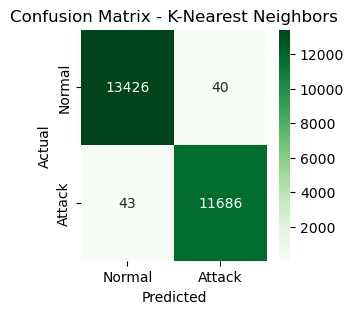

In [45]:
table_knn = [["Accuracy", metrics_knn["Accuracy"]],
         ["Precision", metrics_knn["Precision"]],
         ["Recall", metrics_knn["Recall"]],
         ["F1-Score", metrics_knn["F1-Score"]]]

print("    K-Nearest Neighbors")
print(tabulate(table_knn, headers=["Metric", "Value"], tablefmt="grid", colalign=("center", "center")))
# Matrice di confusione
plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix(y_val, y_pred_knn), annot=True, fmt="d", cmap="Greens", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - K-Nearest Neighbors")
plt.show()

Questi risultati indicano che il modello ha una capacità di classificazione molto elevata, con un numero minimo di falsi positivi e falsi negativi.

Nonostante il numero limitato di errori, è importante notare che KNN è un algoritmo computazionalmente costoso in fase di predizione, specialmente con dataset di grandi dimensioni

# Logistic Regression 

La ricerca degli iperparametri per **Logistic Regression** è stata effettuata con GridSearchCV, ottimizzando il valore della regolarizzazione **C** su scala logaritmica per esplorare efficacemente ordini di grandezza diversi.

La scelta di **GridSearchCV** è motivata dalla necessità di una ricerca esaustiva su un singolo iperparametro critico.

In [57]:
X_train_logistic, X_val_logistic, X_test_logistic = preprocess_pipeline("Logistic_Regression")

# Definisco griglia di iperparametri 
param_grid = {'C': np.logspace(-3, 3, 50)}  # Valori di C su scala logaritmica

# Creazione del modello Logistic Regression
logistic_regression = LogisticRegression(random_state=0, max_iter=1000)

# Cerco il miglior C con GridSearchCV
grid_search = GridSearchCV(logistic_regression, param_grid, cv=10, scoring='f1',verbose=1)
grid_search.fit(X_train_logistic, y_train)

best_C = grid_search.best_params_['C']
print(f"Miglior valore di C trovato: {best_C}")


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Miglior valore di C trovato: 44.98432668969444


In [47]:
X_train_logistic, X_val_logistic, X_test_logistic = preprocess_pipeline("Logistic_Regression")
best_C = 44.98432668969444
# Addestramento del modello 
fitted_regressor = LogisticRegression(C=best_C, random_state=0, max_iter=1000).fit(X_train_logistic, y_train)
y_pred_logistic  = fitted_regressor.predict(X_val_logistic)

# Calcolo dele metriche
metrics_logistic = metrics_score(y_val, y_pred_logistic)
results_dictionary["Logistic Regression"] = metrics_logistic
print("Model fit done: Metrics saved in results_dictionary !")

Model fit done: Metrics saved in results_dictionary !


    Logistic Regression
+-----------+----------+
|  Metric   |  Value   |
+===========+==========+
| Accuracy  | 0.972653 |
+-----------+----------+
| Precision | 0.972771 |
+-----------+----------+
|  Recall   | 0.972653 |
+-----------+----------+
| F1-Score  | 0.972634 |
+-----------+----------+


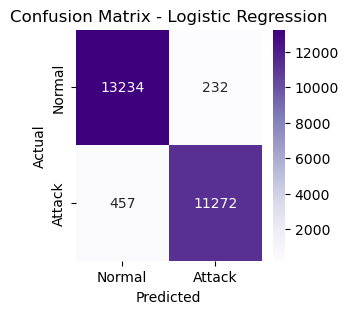

In [49]:
table_logistic = [["Accuracy", metrics_logistic["Accuracy"]],
         ["Precision", metrics_logistic["Precision"]],
         ["Recall", metrics_logistic["Recall"]],
         ["F1-Score", metrics_logistic["F1-Score"]]]

print("    Logistic Regression")
print(tabulate(table_logistic, headers=["Metric", "Value"], tablefmt="grid", colalign=("center", "center")))
# Matrice di confusione
plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix(y_val, y_pred_logistic), annot=True, fmt="d", cmap="Purples", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

L'ottimizzazione del parametro C tramite GridSearchCV ha garantito buoni risultati, migliorando la capacità del modello di adattarsi ai dati senza overfitting. Tuttavia, il numero elevato di falsi negativi suggerisce che il modello potrebbe non essere sufficientemente flessibile per catturare tutte le variazioni nei dati, rendendo le soluzioni precedenti più adatte a questo tipo di task

# Random Forest
L'ottimizzazione degli iperparametri per **Random Forest** è stata effettuata con **HalvingGridSearchCV**, un metodo iterativo che seleziona progressivamente le migliori combinazioni, riducendo il numero di candidati a ogni iterazione. Questo approccio consente di ridurre il costo computazionale, mantenendo un’ottima esplorazione dello spazio degli iperparametri.

I parametri ottimizzati includono:

* **Numero di alberi** (n_estimators)
* **Profondità massima** (max_depth)
* **Criterio di suddivisione** (criterion)
* **Minimo numero di campioni**(min_samples)

In [388]:
X_train_rf, X_val_rf, X_test_rf = preprocess_pipeline("Random_Forest")

# Definizione della griglia di iperparametri
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

# Creazione del modello di Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Implementazione di HalvingGridSearchCV
halving_search = HalvingGridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    factor=3,  # Numero di candidati ridotti a ogni iterazione
    cv=3,
    scoring='f1',
    verbose=1,
    random_state=42
)

# Esegui la ricerca
halving_search.fit(X_train_rf, y_train)

# Miglior set di iperparametri trovato
best_params_rf = halving_search.best_params_
print("Miglior set di iperparametri trovato:", best_params_rf)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 2799
max_resources_: 75583
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 2799
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 1
n_candidates: 24
n_resources: 8397
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 2
n_candidates: 8
n_resources: 25191
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 75573
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Miglior set di iperparametri trovato: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9987
Precision: 0.9987
Recall: 0.9987
F1-Score: 0.9987


In [108]:
X_train_rf, X_val_rf, X_test_rf = preprocess_pipeline("Random_Forest")
#Miglior set di iperparametri trovato: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
best_params_rf = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# Addestramento del miglior modello trovato
fitted_random_forest = RandomForestClassifier(**best_params_rf, random_state=42).fit(X_train_rf, y_train)
y_pred_rf = fitted_random_forest.predict(X_val_rf)

metrics_rf = metrics_score(y_val, y_pred_rf)
results_dictionary["Random Forest"] = metrics_rf
print("Model fit done: Metrics saved in results_dictionary !")

Model fit done: Metrics saved in results_dictionary !


      Random Forest
+-----------+----------+
|  Metric   |  Value   |
+===========+==========+
| Accuracy  | 0.998651 |
+-----------+----------+
| Precision | 0.998652 |
+-----------+----------+
|  Recall   | 0.998651 |
+-----------+----------+
| F1-Score  | 0.99865  |
+-----------+----------+


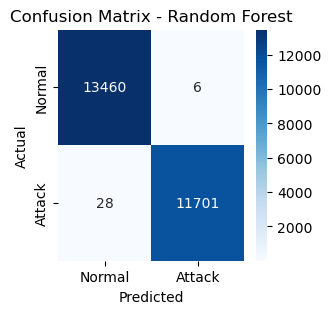

In [110]:
metrics_rf = results_dictionary["Random Forest"]

table_rf = [["Accuracy",  metrics_rf["Accuracy"]],
            ["Precision", metrics_rf["Precision"]],
            ["Recall",    metrics_rf["Recall"]],
            ["F1-Score",  metrics_rf["F1-Score"]]]

print("      Random Forest")
print(tabulate(table_rf, headers=["Metric", "Value"], tablefmt="grid", colalign=("center", "center")))
# Matrice di confusione
plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix(y_val, y_pred_rf), annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

L’ottimizzazione degli iperparametri ha permesso di trovare un compromesso ottimale tra profondità degli alberi e numero di campioni per la suddivisione, garantendo un modello robusto senza overfitting.

La matrice di confusione mostra un numero molto basso di errori, rendendo Random Forest il modello più performante tra quelli testati finora, con un eccellente bilanciamento tra accuratezza e stabilità.

# AdaBoost 

L'ottimizzazione degli iperparametri per **AdaBoost** è stata effettuata con **GridSearchCV**, testando:

* Il **numero di estimatori** (n_estimators)
* Il **learning rate**
* La **profondità del weak learner** (estimator__max_depth)
  
L'uso di **GridSearchCV** con 5-fold cross-validation ha permesso di individuare la miglior combinazione di iperparametri, garantendo un buon compromesso tra bias e varianza.

In [193]:
X_train_ada, X_val_ada, X_test_ada = preprocess_pipeline("AdaBoost")

# Definizione della griglia di ricerca per i migliori iperparametri
param_grid_ada = {
    'n_estimators': [50, 100, 200],  # Numero di alberi nel boosting
    'learning_rate': [0.01, 0.1, 1.0],  # Tasso di apprendimento
    'estimator__max_depth': [1, 2, 3]  # Profondità dell'albero di decisione
}

# Creazione del modello base con un Decision Tree
base_estimator = DecisionTreeClassifier()

# Creazione del modello AdaBoost con il parametro corretto `estimator`
adaboost = AdaBoostClassifier(estimator=base_estimator)

# GridSearchCV per trovare i migliori iperparametri
grid_search = GridSearchCV(
    estimator=adaboost, 
    param_grid=param_grid_ada, 
    cv=5,                # 5-fold cross-validation
    scoring='accuracy',  # Metrica di valutazione
    n_jobs=-1,           # Usa tutti i core disponibili
    verbose=1            # Mostra il progresso della ricerca
)

# Esegui Grid Search
grid_search.fit(X_train_ada, y_train)

# Ottenere i migliori iperparametri
best_params_ada = grid_search.best_params_
print("Migliori iperparametri trovati:", best_params_ada)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\aless\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Migliori iperparametri trovati: {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 200}


In [167]:
X_train_ada, X_val_ada, X_test_ada = preprocess_pipeline("AdaBoost")
#Migliori iperparametri trovati: {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 200}
best_params_ada = {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 200}
adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=best_params_ada['estimator__max_depth']),  # Base learner con la migliore profondità
    n_estimators=best_params_ada['n_estimators'],
    learning_rate=best_params_ada['learning_rate'],
    algorithm='SAMME'  # Variante standard adattiva
)

# Addestramento del modello ottimizzato
adaboost_model.fit(X_train_ada, y_train)

# Predizioni sul validation set
y_pred_ada = adaboost_model.predict(X_val_ada)

# Memorizzazione dei risultati
metrics_ada = metrics_score(y_val, y_pred_ada)
results_dictionary["AdaBoost"] = metrics_ada
print("Model fit done: Metrics saved in results_dictionary !")

Model fit done: Metrics saved in results_dictionary !


      AdaBoost
+-----------+----------+
|  Metric   |  Value   |
+===========+==========+
| Accuracy  | 0.998611 |
+-----------+----------+
| Precision | 0.998611 |
+-----------+----------+
|  Recall   | 0.998611 |
+-----------+----------+
| F1-Score  | 0.998611 |
+-----------+----------+


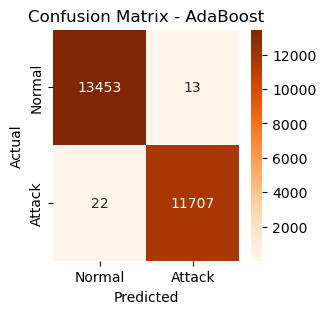

In [169]:
#Miglior set di iperparametri trovato: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
metrics_ada = results_dictionary["AdaBoost"]

table_ada = [["Accuracy",  metrics_ada["Accuracy"]],
            ["Precision", metrics_ada["Precision"]],
            ["Recall",    metrics_ada["Recall"]],
            ["F1-Score",  metrics_ada["F1-Score"]]]

print("      AdaBoost")
print(tabulate(table_ada, headers=["Metric", "Value"], tablefmt="grid", colalign=("center", "center")))
# Matrice di confusione
plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix(y_val, y_pred_ada), annot=True, fmt="d", cmap="Oranges", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - AdaBoost")
plt.show()

L’ottimizzazione ha evidenziato, come visto, gli iperparamentri che producono il miglior modello. Questo indica che **AdaBoost** beneficia di molti weak learners poco complessi, evitando overfitting.

La matrice di confusione mostra pochi errori totali, rendendo AdaBoost una delle migliori scelte per questo problema, con prestazioni comparabili a **Random Forest**.

# Conclusioni
Dall'analisi delle performance dei modelli di machine learning addestrati, emerge che **Random Forest** e **AdaBoost** ottengono le migliori prestazioni in termini di Accuracy, Precision, Recall e F1-Score, rendendoli le scelte più affidabili per il compito di classificazione binaria. Tuttavia, è importante considerare che questi modelli possono essere più lenti in fase di addestramento rispetto a soluzioni più semplici.

**Logistic Regression** e **K-Nearest Neighbors** mostrano prestazioni leggermente inferiori, ma possono essere opzioni valide in scenari in cui la velocità di esecuzione è una priorità. 

<Figure size 1200x800 with 0 Axes>

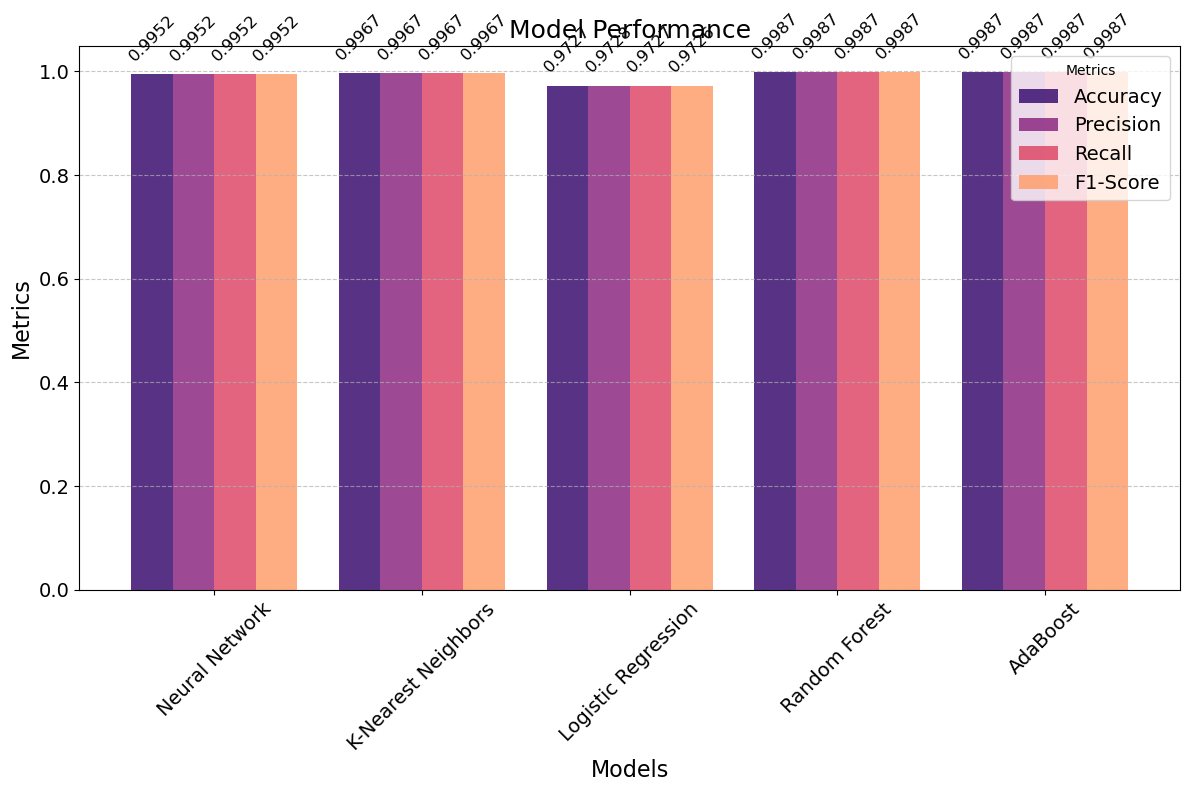

In [108]:
plt.figure(figsize=(12, 8))  # Aumenta la dimensione del grafico
colors = sns.color_palette("magma", len(data.columns))
bars = data.plot(kind='bar', figsize=(12, 8), width=0.8, alpha=0.85, color=colors)

# Aggiungere annotazioni migliorate
for p in bars.patches:
    bars.annotate(
        f'{p.get_height():.4f}', 
        (p.get_x() + p.get_width() / 2, p.get_height() + 0.02),  # Sposta più in alto
        ha='center', va='bottom', fontsize=12, color='black', rotation=45  # Ruota leggermente
    )

plt.title("Model Performance", fontsize=18)
plt.ylabel("Metrics", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.xticks(rotation=45, fontsize=14)  # Ruota le etichette
plt.yticks(fontsize=14)
plt.legend(title="Metrics", fontsize=14, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Test e valutazioni finali
Dopo aver valutato diversi modelli, si è scelto di testare **Random Forest** per la classificazione binaria dei flussi di rete, in quanto ha dimostrato di ottenere alte prestazioni su tutte le metriche.

Dai risultati ottenuti si puo confermare che Random Forest è un'ottima scelta per il problema di classificazione degli attacchi di rete.

      Random Forest
+-----------+----------+
|  Metric   |  Value   |
+===========+==========+
| Accuracy  | 0.998333 |
+-----------+----------+
| Precision | 0.998334 |
+-----------+----------+
|  Recall   | 0.998333 |
+-----------+----------+
| F1-Score  | 0.998333 |
+-----------+----------+


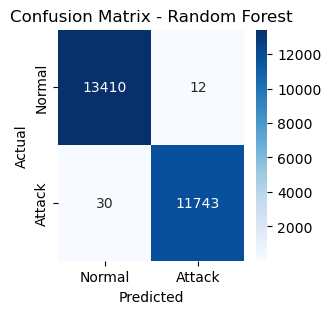

In [112]:
y_pred_rf_t = fitted_random_forest.predict(X_test_rf)

metrics_rf_t = metrics_score(y_test, y_pred_rf_t)

table_rf = [["Accuracy",  metrics_rf_t["Accuracy"]],
            ["Precision", metrics_rf_t["Precision"]],
            ["Recall",    metrics_rf_t["Recall"]],
            ["F1-Score",  metrics_rf_t["F1-Score"]]]

print("      Random Forest")
print(tabulate(table_rf, headers=["Metric", "Value"], tablefmt="grid", colalign=("center", "center")))
# Matrice di confusione
plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_t), annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()